In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [2]:
load_path = "/data/user/tourist/mixed-percision-quantization-for-SwinIR/scripts/large_tensor.pt"


x = torch.load(load_path)
x > 0

/tmp/ipykernel_1496993/157412277.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(load_path)


tensor([[False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False,  True,  True],
        ...,
        [False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False,  True,  True]], device='cuda:0')

In [3]:
loadd_path = "/data/user/tourist/mixed-percision-quantization-for-SwinIR/scripts/weight.pt"
weight = torch.load(loadd_path)


/tmp/ipykernel_1496993/41707444.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(loadd_path)


In [4]:

def draw_plot(weight):
    weight = torch.abs(weight)
    if weight.is_cuda:
        weight = weight.detach().cpu().numpy()
    else:
        weight = weight.numpy()

    input_channels = weight.shape[0]
    output_channels = weight.shape[1]

    X = np.arange(output_channels)
    Y = np.arange(input_channels)
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111, projection='3d')

    top_1_percent_threshold = np.percentile(weight, 99)
    # 创建颜色数组，初始化为蓝色，shape 为 (n, 4) 表示 RGBA 值
    colors = np.zeros((weight.size, 4))

    colors[:] = [0, 0, 1, 0.3]  # 蓝色

    top_1_indices = weight.ravel() >= top_1_percent_threshold
    colors[top_1_indices] = [1, 0, 0, 0.8]  # 红色

    ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(X.ravel()), 0.2, 0.2, weight.ravel(), color=colors)

    ax.set_xlabel('Channel')
    ax.set_ylabel('')
    ax.set_zlabel('Magnitude')

    ax.grid(True)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)



    ax.text2D(0.05, 0.95, "X", transform=ax.transAxes, fontsize=15, weight='bold')
    plt.title(f'input_sampled', fontsize=12)


    plt.show()

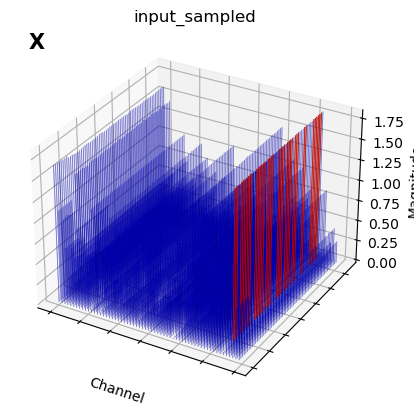

In [5]:
draw_plot(x)

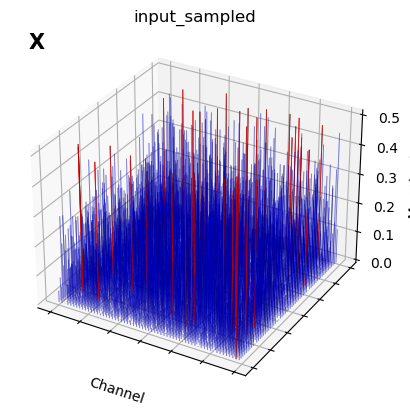

In [177]:
draw_plot(weight)

In [6]:
def uniformity_loss(X):
    return torch.var(X)

def lp_loss(pred, tgt, p=2.0):
    return (pred-tgt).abs().pow(p).mean()
def mse_loss(X, Y):
    return lp_loss(X, Y)

def orth_loss(X, Y):
    I = torch.eye(X.size(0), device=X.device)
    return lp_loss(X @ Y , I)


In [7]:
def quantize(x, max, min):
    n_bits = 2
    delta = (max - min) / (2 ** n_bits - 1)
    zero_point = (- min / delta).round()
    x_int = torch.round(x / delta)
    x_quant = torch.clamp(x_int + zero_point, 0, 2 ** n_bits - 1)
    x_float_q = (x_quant - zero_point) * delta
    return x_float_q

In [8]:
def _quantize(x):
    n_bits = 2
    x_clone = x.clone().detach()
    x_max = x_clone.max()
    x_min = x_clone.min()
    best_score = 1e+10
    best_delta = None
    best_zp = None
    delta = (x_max - x_min) / (2 ** n_bits - 1)
    zero_point = (- x_min / delta).round()
    for pct in [0.9, 0.99, 0.999, 0.9999, 0.99999]:
        try:
            new_max = torch.quantile(x_clone.reshape(-1), pct)
            new_min = torch.quantile(x_clone.reshape(-1), 1.0 - pct)
        except:
            new_max = torch.tensor(np.percentile(
                x_clone.reshape(-1).cpu(), pct * 100),
                device=x_clone.device,
                dtype=torch.float32)
            new_min = torch.tensor(np.percentile(
                x_clone.reshape(-1).cpu(), (1 - pct) * 100),
                device=x_clone.device,
                dtype=torch.float32)   

        x_q = quantize(x_clone, new_max, new_min)
        score = lp_loss(x_clone, x_q, p=2)

        if score < best_score:
            best_score = score
            best_delta = (new_max - new_min) / (2 ** n_bits - 1)
            best_zp = (- new_min / delta).round()

    x_int = torch.round(x / best_delta) + best_zp
    x_quant = torch.clamp(x_int, 0, 2 ** n_bits - 1)
    x_dequant = (x_quant - best_zp) * best_delta

    return x_dequant

In [305]:
def compute_total_loss(X,W, A, B):
    # 计算 XA

    A = A.cuda()
    B = B.cuda()
    origin = torch.matmul(X, W)

    XA = torch.matmul(X, A)
    #BW = torch.matmul(B, weight)
    BW = torch.matmul(B, weight)
   
    uniform_loss = uniformity_loss(XA) * 2 + uniformity_loss(BW)
    xa = _quantize(XA)
    bw = _quantize(BW)

    mseloss = mse_loss(xa @ bw, origin)

    orthloss = orth_loss(A, B)
    
    total_loss =  uniform_loss * 1.5 + orthloss*80 + mseloss * 3
    return total_loss, orthloss, mseloss, uniform_loss


In [320]:


def initialize_orthogonal_matrix(size):
    q, _ = torch.qr(torch.randn(size, size))
    return nn.Parameter(q)


A = initialize_orthogonal_matrix(60, weight.device)
B = initialize_orthogonal_matrix(60, weight.device)

optimizer = optim.Adam([A, B], lr=0.02)
epochs = 100

ModuleNotFoundError: No module named 'utils'

In [312]:
for epoch in range(epochs):
    optimizer.zero_grad()

    # 计算总损失
    total_loss, orth, mmse, uni = compute_total_loss(x, weight, A, B)
    
    # 反向传播和优化
    total_loss.backward()
    optimizer.step()
    
    # 打印损失
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item()}, orth Loss: {orth.item()}, quant_mse Loss: {mmse.item()}, Uniform Loss: {uni.item()}")

Epoch 0, Total Loss: 10.510883331298828, orth Loss: 0.03334468603134155, quant_mse Loss: 2.152209520339966, Uniform Loss: 0.9244528412818909
Epoch 10, Total Loss: 5.448162078857422, orth Loss: 0.004565734416246414, quant_mse Loss: 1.6435354948043823, Uniform Loss: 0.10153130441904068
Epoch 20, Total Loss: 4.816518306732178, orth Loss: 0.0018323316471651196, quant_mse Loss: 1.5234684944152832, Uniform Loss: 0.06635096669197083
Epoch 30, Total Loss: 3.6968042850494385, orth Loss: 0.0009486101916991174, quant_mse Loss: 1.1831252574920654, Uniform Loss: 0.04769311845302582
Epoch 40, Total Loss: 4.326234817504883, orth Loss: 0.0006317884544841945, quant_mse Loss: 1.4081974029541016, Uniform Loss: 0.03406646102666855
Epoch 50, Total Loss: 4.337849140167236, orth Loss: 0.0004265829629730433, quant_mse Loss: 1.4198614358901978, Uniform Loss: 0.029425418004393578
Epoch 60, Total Loss: 4.165736675262451, orth Loss: 0.00035857310285791755, quant_mse Loss: 1.3666362762451172, Uniform Loss: 0.02476

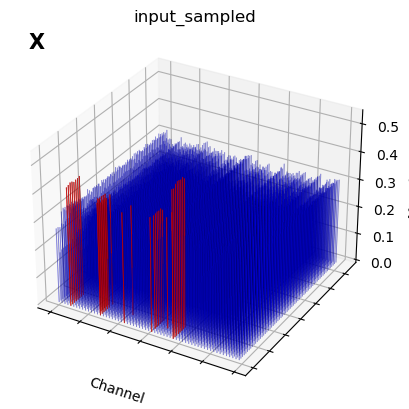

In [313]:

draw_plot(x @ A.cuda())

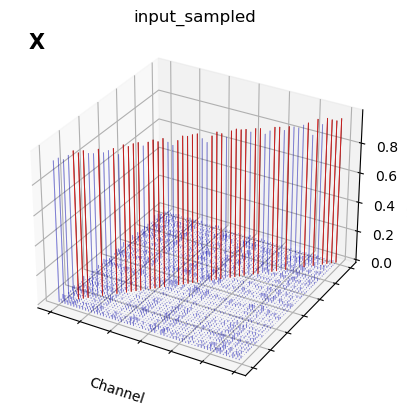

tensor([[ 9.4197e-01, -1.4593e-02, -4.2782e-02,  ..., -3.0845e-02,
          7.4930e-03,  8.0226e-03],
        [-9.4371e-03,  9.5522e-01, -1.3409e-02,  ..., -1.1126e-02,
          2.4272e-02,  1.7297e-02],
        [-3.0741e-02, -2.4407e-03,  9.4126e-01,  ..., -2.4311e-02,
          1.5024e-02, -2.9039e-04],
        ...,
        [-8.2431e-03, -1.1871e-02, -7.3050e-03,  ...,  9.7936e-01,
          9.8497e-03,  4.5618e-03],
        [-2.6079e-03,  1.5580e-02,  8.6412e-03,  ...,  1.5884e-03,
          9.6893e-01, -3.6934e-03],
        [ 4.5806e-03,  1.0830e-02,  1.0190e-02,  ...,  5.0730e-03,
         -7.8517e-03,  9.7972e-01]], device='cuda:0', grad_fn=<MmBackward0>)

In [314]:
s = A.cuda() @ B.cuda()
draw_plot(s)
s

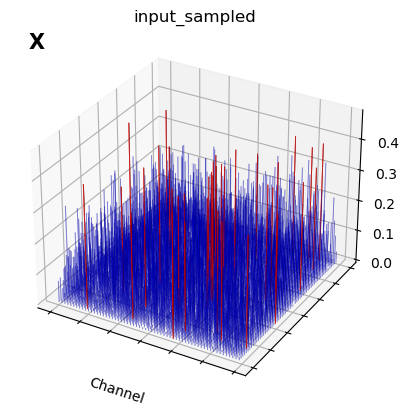

In [315]:
draw_plot(B.cuda() @ weight)